In [4]:
# Data Preparation

In [5]:
import numpy as np
import pandas as pd
import hvplot.pandas

%matplotlib inline

In [6]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)
from sklearn.preprocessing import MinMaxScaler


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [7]:
# Load the Valero daily data
df = pd.read_csv('../data/cleandata/Data.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)
#df = df.drop(columns=["Open", "High", "Low", "Adj Close", "Volume"])
df.head()

,Crude1,WTI_Midland,Brent,RBOB,Ethanol,Corn,CAD_Heavy,VIX,ULSD,OPEC_Basket,RBOB_Crack,GC_ULSD_Crack,NY_ULSD_Crack,NG_HB,S_P,VLO
Date,,,,,,,,,,,,,,,,
2017-01-05,53.76,-0.06,56.89,1.6377,1.507,361.25,-15.044,13.025,1.6942,53.02,21.45,14.58,17.13,3.273,2264.3,60.913052
2017-01-06,53.99,-0.11,57.10,1.6340,1.551,358.00,-14.459,12.875,1.7032,53.50,21.45,14.69,17.27,3.285,2271.5,59.995037
2017-01-09,51.96,-0.22,54.94,1.5707,1.524,360.00,-14.296,12.925,1.6376,52.85,20.94,14.27,16.68,3.103,2265.0,59.734032
2017-01-10,50.82,-0.17,53.64,1.5467,1.503,358.25,-14.193,12.875,1.6114,51.46,21.15,14.44,16.72,3.278,2263.7,59.878029
2017-01-11,52.25,-0.17,55.10,1.5929,1.492,357.25,-14.232,12.525,1.6524,50.98,21.64,14.67,16.96,3.224,2270.6,60.373043


In [8]:
number_units = 10
dropout_fraction = 0.2

In [9]:
def LSTM_F(df):


    def window_data(df, window, feature_col_number, target_col_number):
        X = []
        y = []
        for i in range(len(df) - window - 1):
            features = df.iloc[i:(i + window), feature_col_number]
            target = df.iloc[(i + window), target_col_number]
            X.append(features)
            y.append(target)
        return np.array(X), np.array(y).reshape(-1, 1)

    window_size =3

    # Column index 1 is the `Close` column
    feature_column = 15
    target_column = 15
    X, y = window_data(df, window_size, feature_column, target_column)
    
    # Use 70% of the data for training and the remainder for testing
    split = int(0.7 * len(X))
    X_train = X[: split - 1]
    X_test = X[split:]
    y_train = y[: split - 1]
    y_test = y[split:]
    
    # Use MinMaxScaler to scale the data between 0 and 1. 
    

    scaler = MinMaxScaler()
    scaler.fit(X)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    scaler.fit(y)
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    model = Sequential()

    number_units = 10
    dropout_fraction = 0.2

    # Layer 1
    model.add(LSTM(
        units=number_units,
        return_sequences=True,
        input_shape=(X_train.shape[1], 1))
        )
    model.add(Dropout(dropout_fraction))
    # Layer 2
    model.add(LSTM(units=number_units, return_sequences=True))
    model.add(Dropout(dropout_fraction))
    # Layer 3
    model.add(LSTM(units=number_units))
    model.add(Dropout(dropout_fraction))
    # Output layer
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    #train the model
    
    model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)    
   
    predicted = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(predicted)
    real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))    
    
    model_eval = model.evaluate(X_test, y_test)
        
   
        
    
    stocks = pd.DataFrame({"Real": real_prices.ravel(),"Predicted": predicted_prices.ravel()})   
    stocks_ =stocks.tail()
    stocks_plot = stocks.plot()    
    
    return  model_eval, stocks, stocks_plot  


Epoch 1/10
419/419 [==============================] - 9s 6ms/step - loss: 0.0083
Epoch 2/10
419/419 [==============================] - 3s 6ms/step - loss: 0.0244
Epoch 3/10
419/419 [==============================] - 3s 6ms/step - loss: 0.0251
Epoch 4/10
419/419 [==============================] - 3s 6ms/step - loss: 0.0177
Epoch 5/10
419/419 [==============================] - 3s 7ms/step - loss: 0.0114
Epoch 6/10
419/419 [==============================] - 3s 7ms/step - loss: 0.0089
Epoch 7/10
419/419 [==============================] - 2s 6ms/step - loss: 0.0083
Epoch 8/10
419/419 [==============================] - 2s 5ms/step - loss: 0.0067
Epoch 9/10
419/419 [==============================] - 2s 5ms/step - loss: 0.0061
Epoch 10/10
6/6 [==============================] - 1s 2ms/step - loss: 0.0266


(0.026583880186080933,
            Real   Predicted
 0    109.008568  111.888428
 1    109.133141  111.776634
 2    110.704781  111.493011
 3    114.988464  111.251778
 4    112.333931  111.409004
 ..          ...         ...
 176   81.011757   85.952591
 177   79.874367   87.233330
 178   80.734825   89.300499
 179   83.998634   90.711922
 180   83.009605   90.566795
 
 [181 rows x 2 columns],
 <AxesSubplot:>)

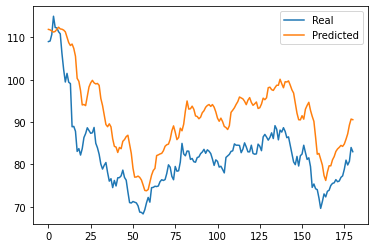

In [10]:
LSTM_F(df)

In [11]:
# Compile the model
